In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# unmount google drive directory code 
# drive.flush_and_unmount()

Mounted at /content/drive


In [ ]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer



!pip install tweet-preprocessor
import preprocessor as p

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# set working directory -> you must set the path into which you have uploaded the data file
# this is required in the case of colab
%cd /content/drive/My\ Drive/DMTM/Research Project 

/content/drive/My Drive/DMTM/Research Project


In [ ]:
DATAFILE = 'training-Obama-Romney-tweets.xlsx'
df_obama = pd.read_excel(DATAFILE, sheet_name=0, header=None,index_col=None, usecols='B:F', 
                   skiprows=[0,1], names=['date', 'time', 'tweet','class','result'])
df_romney = pd.read_excel(DATAFILE, sheet_name=1, header=None,index_col=None, usecols='B:F', 
                   skiprows=[0,1], names=['date', 'time', 'tweet','class','result'])

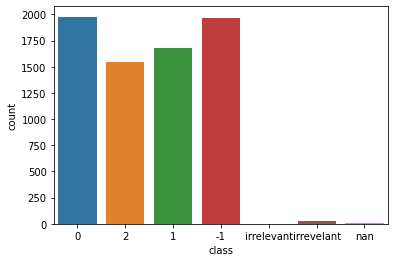

In [ ]:
#Cast the results column to string since it contains both 2 & '2'
df_obama['class'] = df_obama['class'].astype(str)
sns.countplot(x = 'class', data = df_obama)

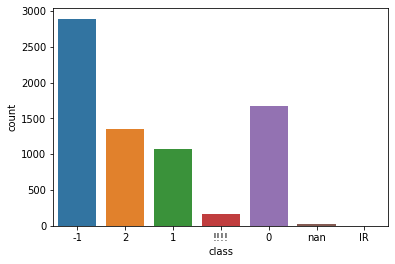

In [ ]:
df_romney['class'] = df_romney['class'].astype(str)
sns.countplot(x = 'class', data = df_romney)

In [ ]:
# Drop rows not having 0, 1, -1
df_obama = df_obama[df_obama['class'].isin(['0', '1', '-1'])] 
df_romney = df_romney[df_romney['class'].isin(['0', '1', '-1'])] 

# Print the shape of the dataframe 
print(df_obama.shape) 
print(df_romney.shape) 


(5625, 5)
(5648, 5)


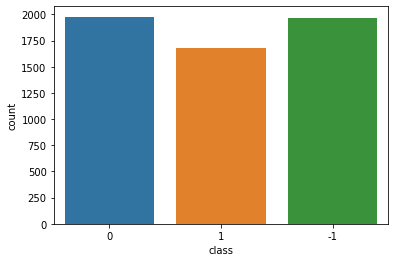

In [ ]:
sns.countplot(x = 'class', data = df_obama)

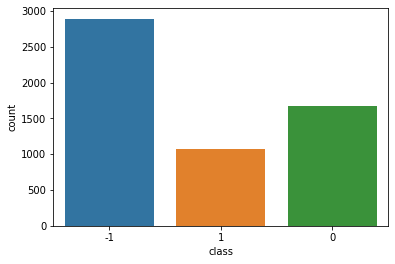

In [ ]:
sns.countplot(x = 'class', data = df_romney)

In [ ]:
df_obama['tweet'] = df_obama['tweet'].astype(str)
df_obama['tweet_length'] = df_obama['tweet'].apply(lambda x: len(str(x)))
#df_obama.head(20)
#sns.barplot('tweet','tweet_length',data = df_obama,palette='PRGn')

In [ ]:
df_romney['tweet'] = df_romney['tweet'].astype(str)
df_romney['tweet_length'] = df_romney['tweet'].apply(lambda x: len(str(x)))

In [ ]:
# Now define the way we we clean the tweets 
def clean_sentence(tweet):
    tweet = re.sub(re.compile('<[^>]+>'), '', tweet)
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

def clean_stopwords(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

# lexical normalization
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet
    

In [ ]:
# clean the tweets in the datatable
df_obama['tweet_cleaned'] = df_obama['tweet'].apply(lambda x: normalization(clean_stopwords(clean_sentence(x))))
df_obama.head(10)
df_romney['tweet_cleaned'] = df_romney['tweet'].apply(lambda x: normalization(clean_stopwords(clean_sentence(x))))
df_romney.head(10)

,date,time,tweet,class,result,tweet_length,tweet_cleaned
0,2012-10-16 00:00:00,09:38:08-05:00,Insidious!<e>Mitt Romney</e>'s Bain Helped Phi...,-1,NaN,146,"[Insidious, Mitt, Romney, Bain, Helped, Philip..."
2,2012-10-16 00:00:00,10:14:18-05:00,.@WardBrenda @shortwave8669 @allanbourdius you...,-1,NaN,97,"[WardBrenda, allanbourdius, mean, like, romney..."
3,2012-10-16 00:00:00,09:27:16-05:00,<e>Mitt Romney</e> still doesn't <a>believe</a...,-1,NaN,86,"[Mitt, Romney, still, believe, black, president]"
4,2012-10-16 00:00:00,10:11:43-05:00,<e>Romney</e>'s <a>tax plan</a> deserves a 2nd...,-1,NaN,158,"[Romney, tax, plan, deserve, look, secret, one..."
5,2012-10-16 00:00:00,10:13:17-05:00,Hope <e>Romney</e> debate prepped w/ the same ...,1,NaN,66,"[Hope, Romney, debate, prepped, w, people, las..."
6,2012-10-16 00:00:00,10:17:28-05:00,Want to know how <e>Mitt Romney</e> is going t...,-1,NaN,145,"[Want, know, Mitt, Romney, go, able, cut, tril..."
7,2012-10-16 00:00:00,09:35:55-05:00,If <e>Romney</e> wins the <a>presidential elec...,-1,NaN,97,"[Romney, win, presidential, election, worlds, ..."
10,2012-10-16 00:00:00,10:28:50-05:00,<e>Romney</e>'s <a>12 million jobs scam </a>re...,-1,NaN,130,"[Romney, million, job, scam, remind, Rip, Torn..."
12,2012-10-16 00:00:00,10:21:31-05:00,<e>Mitt #Romney</e> <a>said</a> that <a> catch...,-1,NaN,161,"[Mitt, Romney, say, catch, Osama, bin, Laden, ..."
13,2012-10-16 00:00:00,10:26:34-05:00,Please be<e> Mitt Romney</e> “@HuffingtonPost:...,0,NaN,122,"[Please, Mitt, Romney, HuffingtonPost, Honey, ..."


In [ ]:
def text_processing(x):
  new_tweet = clean_sentence(x)
  no_punc_tweet = clean_stopwords(new_tweet)
  return normalization(no_punc_tweet)

pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

msg_train, msg_test, label_train, label_test = train_test_split(df_obama['tweet'], df_obama['class'], test_size=0.1)
pipeline.fit(msg_train,label_train)


predictions = pipeline.predict(msg_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))


              precision    recall  f1-score   support

          -1       0.72      0.56      0.63       261
           0       0.49      0.57      0.53       173
           1       0.56      0.68      0.61       129

    accuracy                           0.59       563
   macro avg       0.59      0.61      0.59       563
weighted avg       0.61      0.59      0.60       563



[[147  77  37]
 [ 41  99  33]
 [ 17  24  88]]
0.5932504440497336


In [ ]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SGDClassifier()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

msg_train, msg_test, label_train, label_test = train_test_split(df_obama['tweet'], df_obama['class'], test_size=0.2)
pipeline.fit(msg_train,label_train)


predictions = pipeline.predict(msg_test)

print(classification_report(predictions,label_test))
print ('\n')
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))


              precision    recall  f1-score   support

          -1       0.63      0.57      0.60       425
           0       0.50      0.56      0.53       343
           1       0.61      0.60      0.60       357

    accuracy                           0.58      1125
   macro avg       0.58      0.58      0.58      1125
weighted avg       0.58      0.58      0.58      1125



[[243 115  67]
 [ 79 192  72]
 [ 64  79 214]]
0.5768888888888889


In [ ]:
sns.countplot(x= 'tweet',data = df_obama)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 157 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128299 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127846 missing from current font.
  font.set_

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fe1588d4510> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 432x288 with 1 Axes>